# Load Images and Measurements

In [1]:
import csv
import matplotlib.pyplot as plt
from os.path import isfile
import cv2
import numpy as np
%matplotlib inline

log_dirs = ('Simulator_Images', 'Simulator_Images_2')
img_dirs = ["/".join([log_dir, "IMG"]) for log_dir in log_dirs]
log_files = ["/".join([log_dir, "driving_log.csv"]) for log_dir in log_dirs]

def file_exists(file_name):
    for base_path in img_dirs:
        full_name = "/".join([".", base_path, file_name])
        if isfile(full_name):
            return (True, full_name)
        
    return (False, None)


center_image_names = []
center_image_measurements = []

thres = 1
for log_file in log_files:
    with open(log_file, 'r') as csv_file:
        filereader = csv.reader(csv_file)
        for row in filereader:
            file_name = row[0].split('\\')[-1]
            
            is_present, full_name = file_exists(file_name)
            if is_present:
                center_image_names.append(full_name)
                measurement = float(row[-1])
                center_image_measurements.append(measurement)

                thres = thres + 1
                
            if thres > 3000:
                break

    if thres > 3000:
        break

print ("Number of images: {}".format(len(center_image_names)))

Number of images: 3000


In [2]:
ex_img = cv2.imread(center_image_names[0])
num_rows = len(ex_img[:, 0, 0])
#ex_img = ex_img[crop_top_rows:(num_rows - crop_bottom_rows), 0:320]

image_shape = np.array(ex_img).shape[0:]
print ("Image shape is {}".format(image_shape))

Image shape is (160, 320, 3)


In [3]:
from sklearn.model_selection import train_test_split

train_image_samples, validation_image_samples, train_angle_samples, validation_angle_samples = train_test_split(
     center_image_names, center_image_measurements, test_size=0.33, random_state=42)

In [4]:
from sklearn.utils import shuffle
import numpy as np

def sample_generator(samples, batch_size):
    num_samples = len(list(samples))
    
    while 1:
        shuffle(samples)
        for i in range(0, num_samples, batch_size):
            batch_samples = samples[i : i + batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                center_image = cv2.imread(sample[0])
                images.append(center_image)
                angles.append(sample[1])
        
            image_set = np.array(images, dtype=np.float32)
            angle_set = np.array(angles, dtype=np.float32)
            yield shuffle(image_set, angle_set)

In [5]:
batch_size=32
train_data = list(zip(train_image_samples, train_angle_samples))
val_data = list(zip(validation_image_samples, validation_angle_samples))
train_generator = sample_generator(train_data, batch_size = batch_size)
validation_generator = sample_generator(val_data, batch_size = batch_size)

In [6]:
### Test generator
i = 0
for entry in train_generator:
    #print (entry)
    i = i + 1
    if i > 0:
        break

# Model Architecture

Using TensorFlow backend.


(160, 320, 3)
Epoch 1/7
4s - loss: 62.9971 - acc: 0.0000e+00 - precision: 1.1721 - recall: 0.9906 - val_loss: 7.4285 - val_acc: 0.0000e+00 - val_precision: 0.9990 - val_recall: 1.0010
Epoch 2/7
3s - loss: 5.2365 - acc: 0.0000e+00 - precision: 0.9970 - recall: 1.0005 - val_loss: 4.4726 - val_acc: 0.0000e+00 - val_precision: 0.9980 - val_recall: 1.0000
Epoch 3/7
3s - loss: 3.0307 - acc: 0.0000e+00 - precision: 0.9970 - recall: 1.0000 - val_loss: 3.7715 - val_acc: 0.0000e+00 - val_precision: 0.9980 - val_recall: 1.0000
Epoch 4/7
3s - loss: 2.1492 - acc: 0.0000e+00 - precision: 0.9975 - recall: 1.0000 - val_loss: 3.4021 - val_acc: 0.0000e+00 - val_precision: 0.9980 - val_recall: 1.0000
Epoch 5/7
3s - loss: 1.6002 - acc: 0.0000e+00 - precision: 0.9975 - recall: 1.0000 - val_loss: 3.1723 - val_acc: 0.0000e+00 - val_precision: 0.9990 - val_recall: 1.0000
Epoch 6/7
3s - loss: 1.2289 - acc: 0.0000e+00 - precision: 0.9980 - recall: 1.0000 - val_loss: 3.0414 - val_acc: 0.0000e+00 - val_precision:

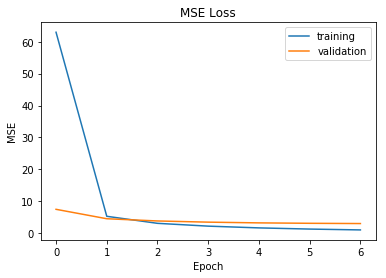

In [7]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.core import Flatten, Dense, Lambda
from keras.layers.convolutional import Cropping2D

train_sample_size = len(train_image_samples)
val_sample_size = len(validation_image_samples)
print (image_shape)

Max_Pixel_Value = 255.0
Pixel_Mean = 0.5

model = Sequential()
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=image_shape))
model.add(Lambda(lambda x: (x / Max_Pixel_Value) - Pixel_Mean ))
model.add(Flatten())
model.add(Dense(1))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy', 'precision', 'recall'])
hist = model.fit_generator(train_generator, samples_per_epoch = train_sample_size, nb_epoch=7, verbose=2,
                           validation_data=validation_generator, nb_val_samples = val_sample_size)
print (hist.history.keys())

### plt the training and validation loss for each epoch
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("MSE Loss")
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc = 'upper right')
plt.show()

model.save('model.h5')